<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---


#**Projeto de Conclusão do Curso de Análise de Dados**#


###Pipeline de dados do Telegram#

---



*Neste projeto vamos criar um Pipeline de dados obtidos de um grupo de mensagens do Telegram e usar o AWS para armazenamento, tratamento e apresendação dos dados*



# **Tópicos**

<ol type="1">
  <li>Arquitetura;</li>
  <li>Ingestão;</li>
  <li>ETL;</li>
  <li>Apresentação;</li>
  <li>Storytelling.</li>
</ol>

## 1\. Arquitetura


**1 Estrutura do Pipeline de dados**

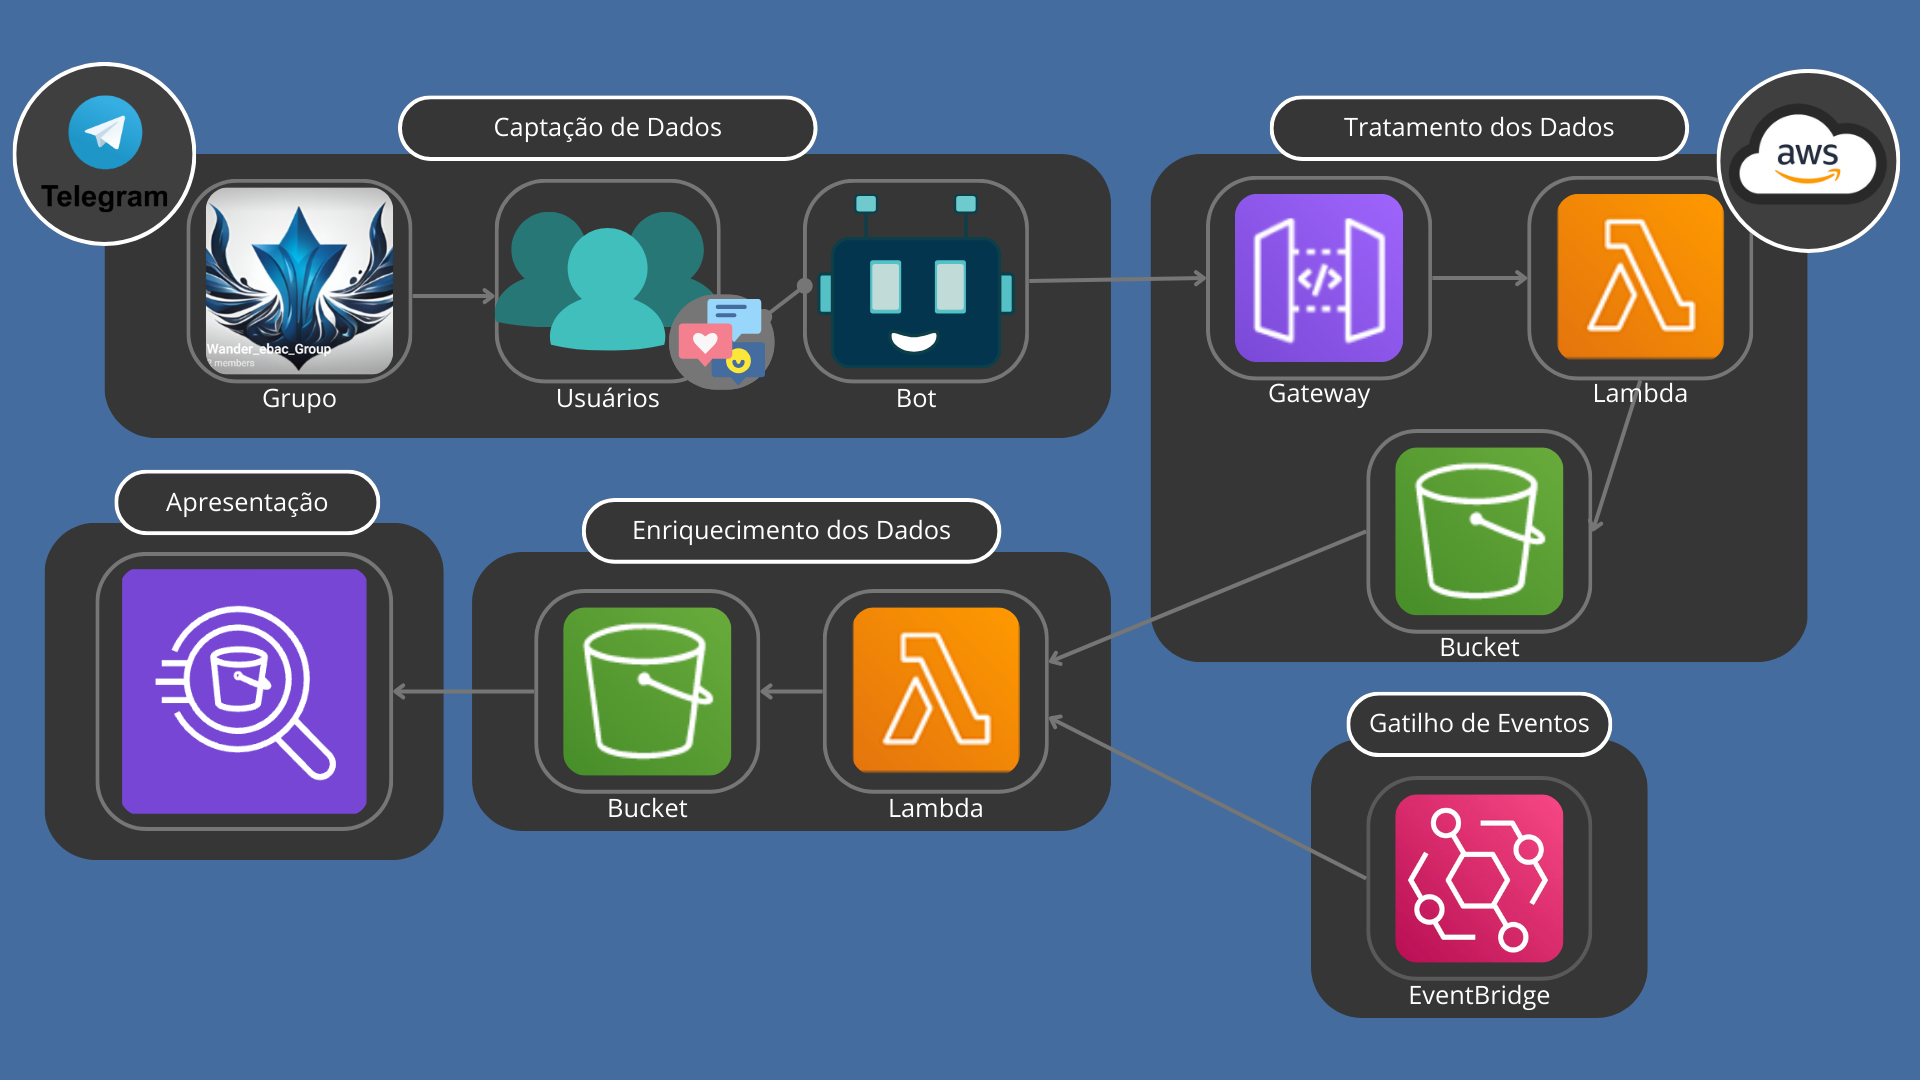

---

## 2\. Ingestão

2.1. Criado `bucket wander-curso-ebac-modulofinal-raw no AWS S3` para o armazenamento de dados crus.

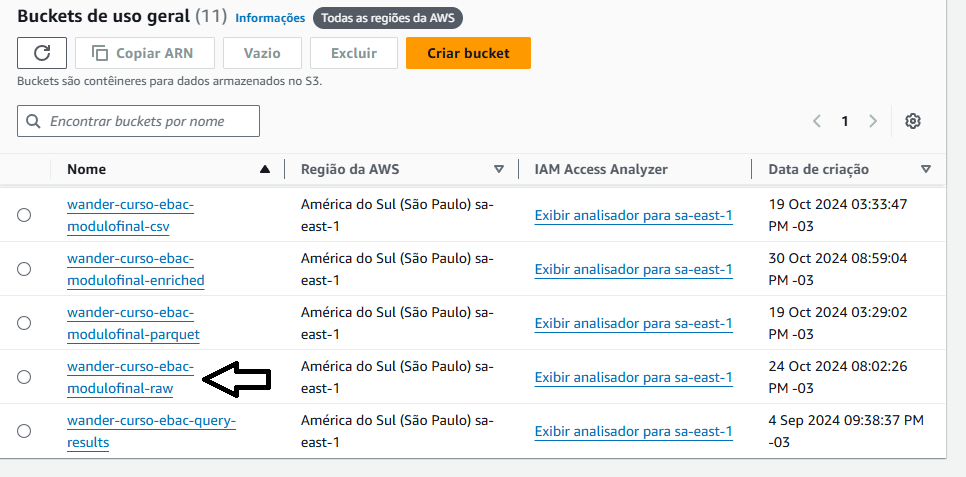

2.2. Função no `AWS Lambda` para recebimento das mensagens e armazenamento no formato JSON no `bucket` de dados crus.

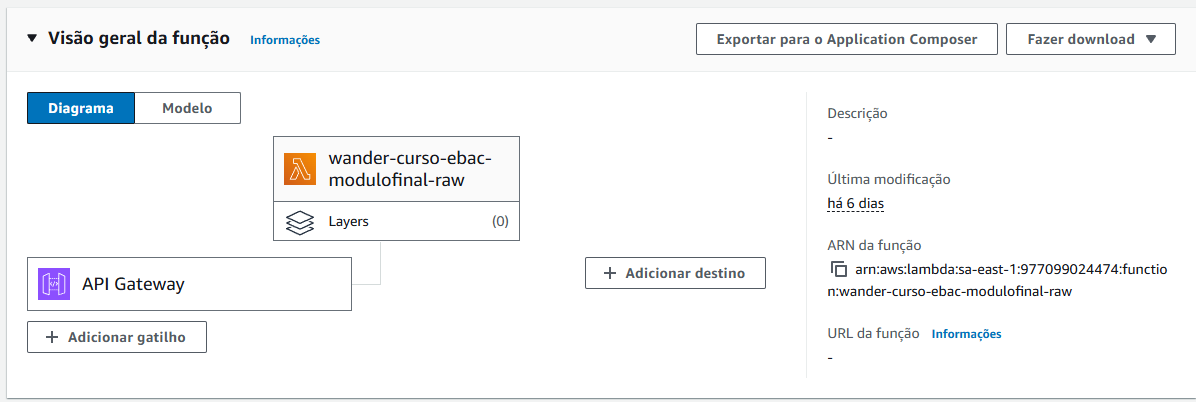

*Criado variaveis de ambiente para salvar o nome do bucket e ID do chat*


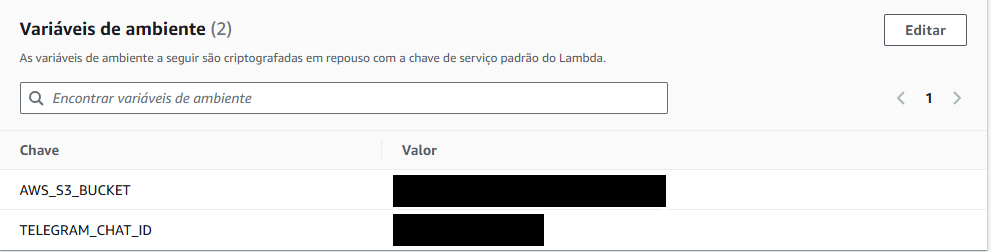

In [ ]:
# Codigo da função Lambda para extrair os dados crus.
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    # Codigo para integracao da funcao com o AWS API Gateway
    message = json.loads(event["body"])

    # Codigo para evento de testa da funcao Lambda
    #message = event

    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error("Exception occurred", exc_info=True)
      # loging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

2.3. Criação da API no `AWS API Gateway`

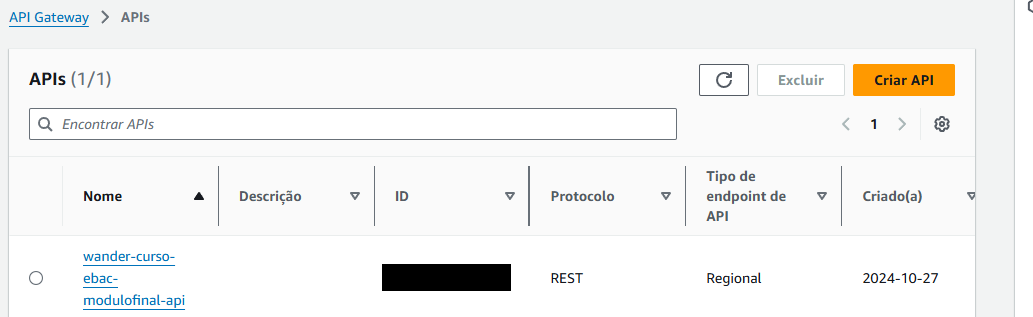

*Metodo Post da API*

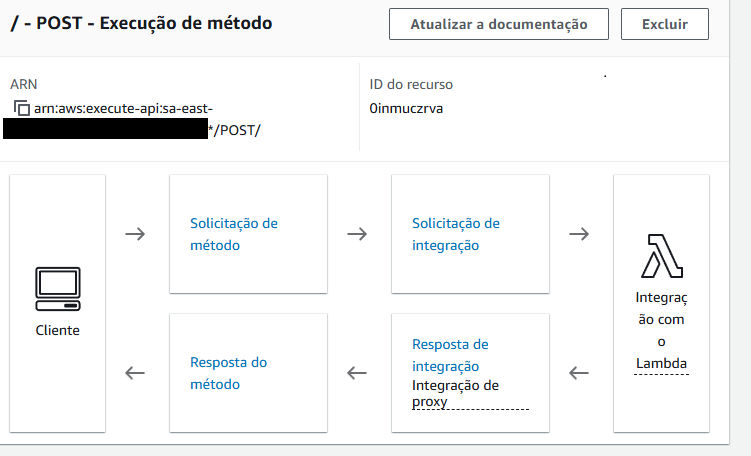

2.4. Configurando o *webhook* do *bot* através do método `setWebhook` da API do **Telegram**. utilizando a URL criada no `AWS API Gateway` criando a
integração com o método `getWebhookInfo`.

In [ ]:
# Salvando a URL gerada no AWS API_Gateway0
aws_api_gateway_url = getpass()

# Configurando o WebHook para o redirecionamento das mensagens do bot para a API
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))


## 3\. ETL

3.1. Criação do `bucket wander-curso-ebac-modulofinal-enriched  no AWS S3` para o armazenamento de dados enriquecidos.

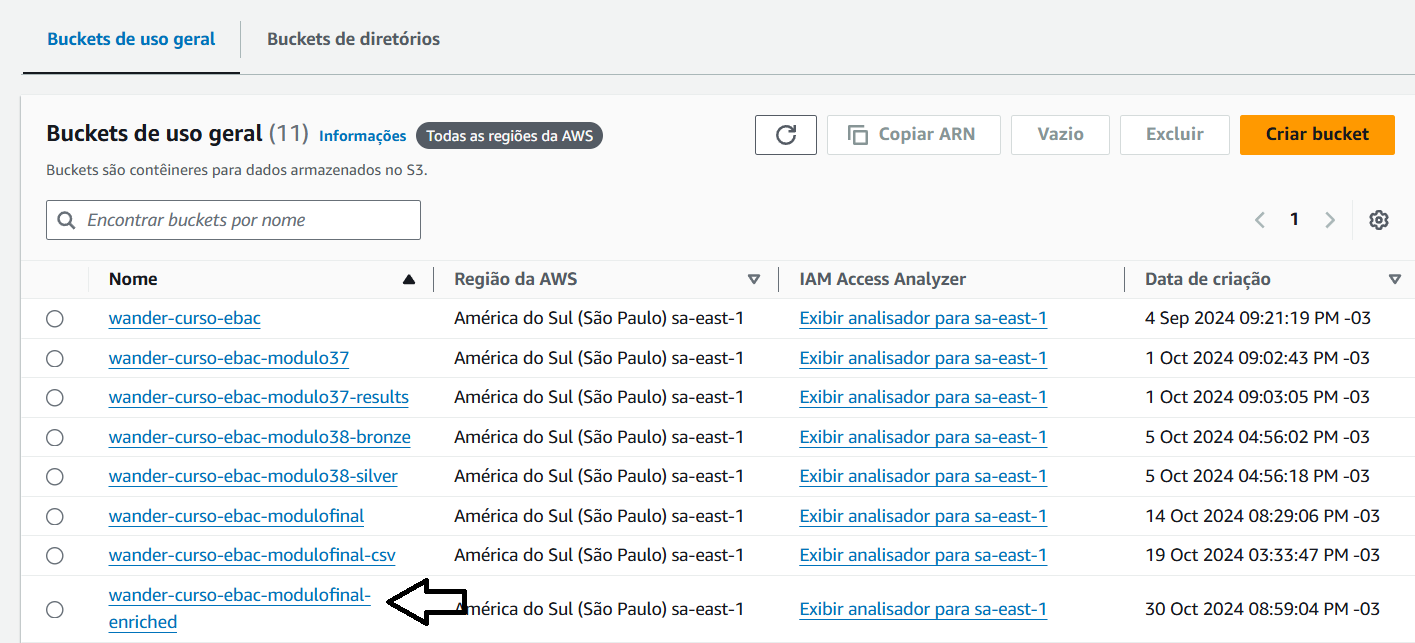

*3.2 Funçao Lambda no AWS para tratamento do dados em formato JSON particionados por data (D-1) que foram armazenadas no Bucket de dados crus, salvos em um arquivo Parquet tambem particionado por data.*

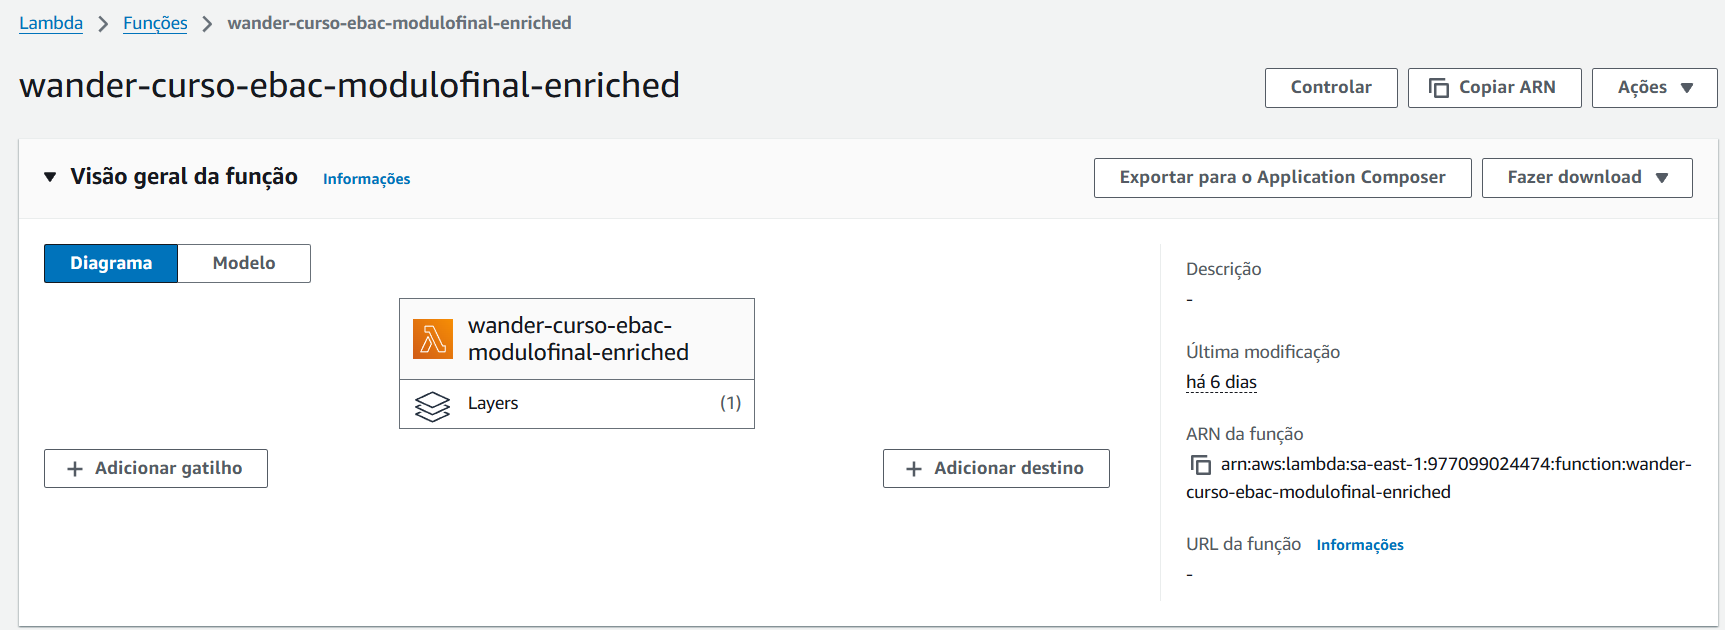

*3.3 Criaçao das variaveis de ambiente usadas na função `Lambda enriched`*

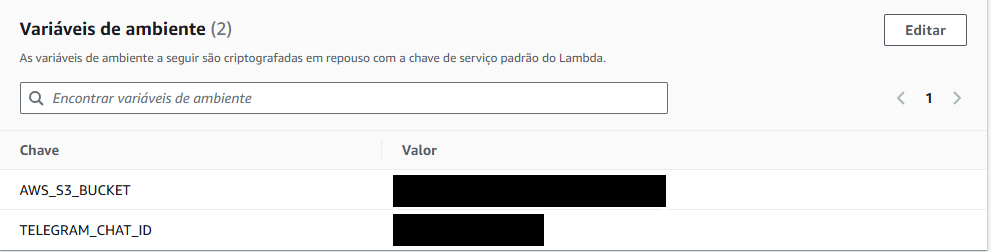

In [ ]:
"""
Codigo da Função Lambda para processar os dados crus, fazer o processo de  ETL
e salvar no bucket enriched no formato Parquert, particionado por data.
"""


import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False


3.4. Criado regra no `AWS Event Bridge` para executar a função do `AWS Lambda` todo dia durante a madrugada.

## 4\. Apresentação

4.1. Tabela do `AWS Athena` com os  dados extraidos do bucket enriched do `AWS S3`.

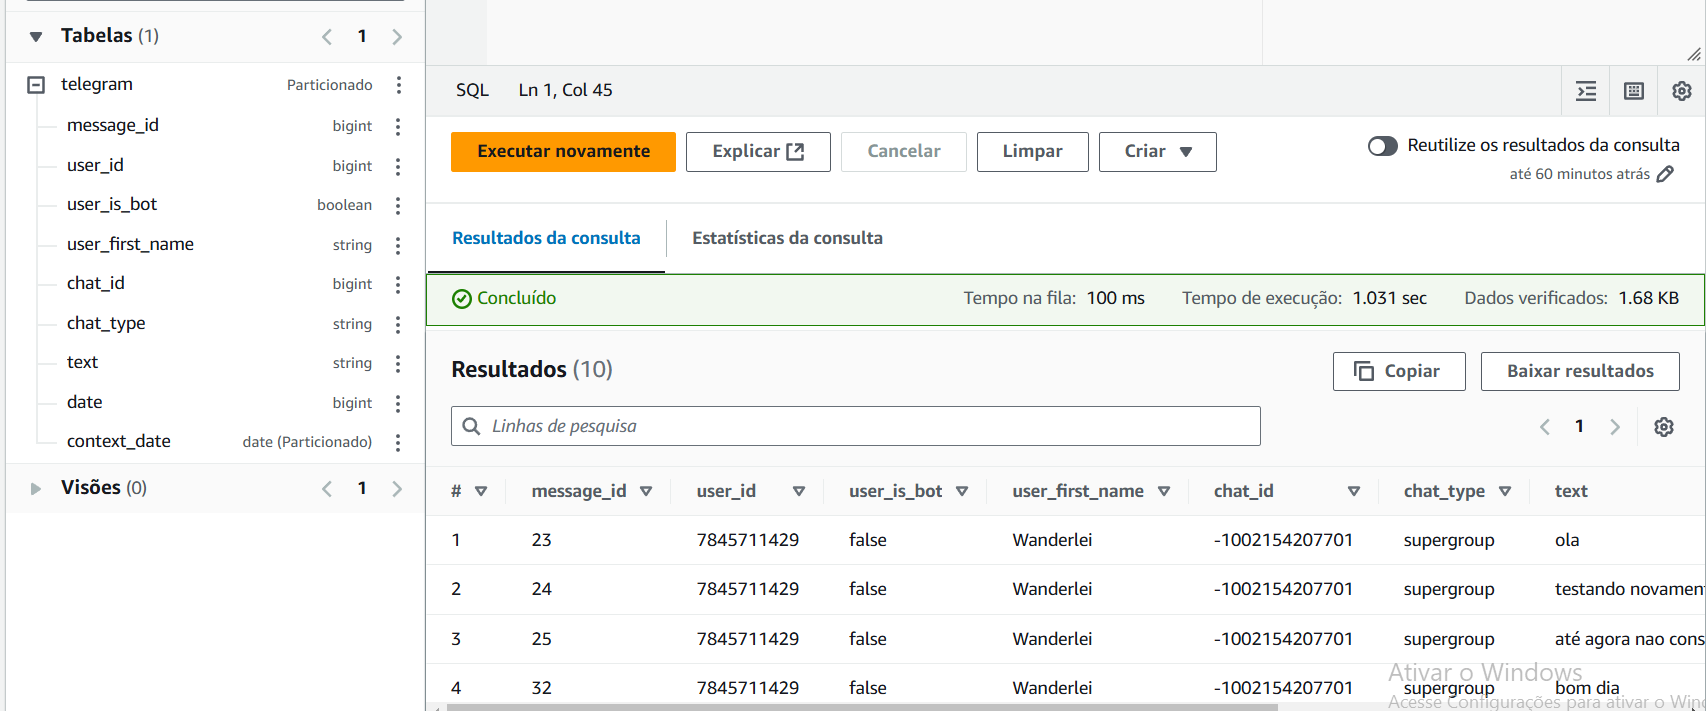

4.2. Resultado do comando `MSCK REPAIR` para carga dos dados do dia anterior (D-1).

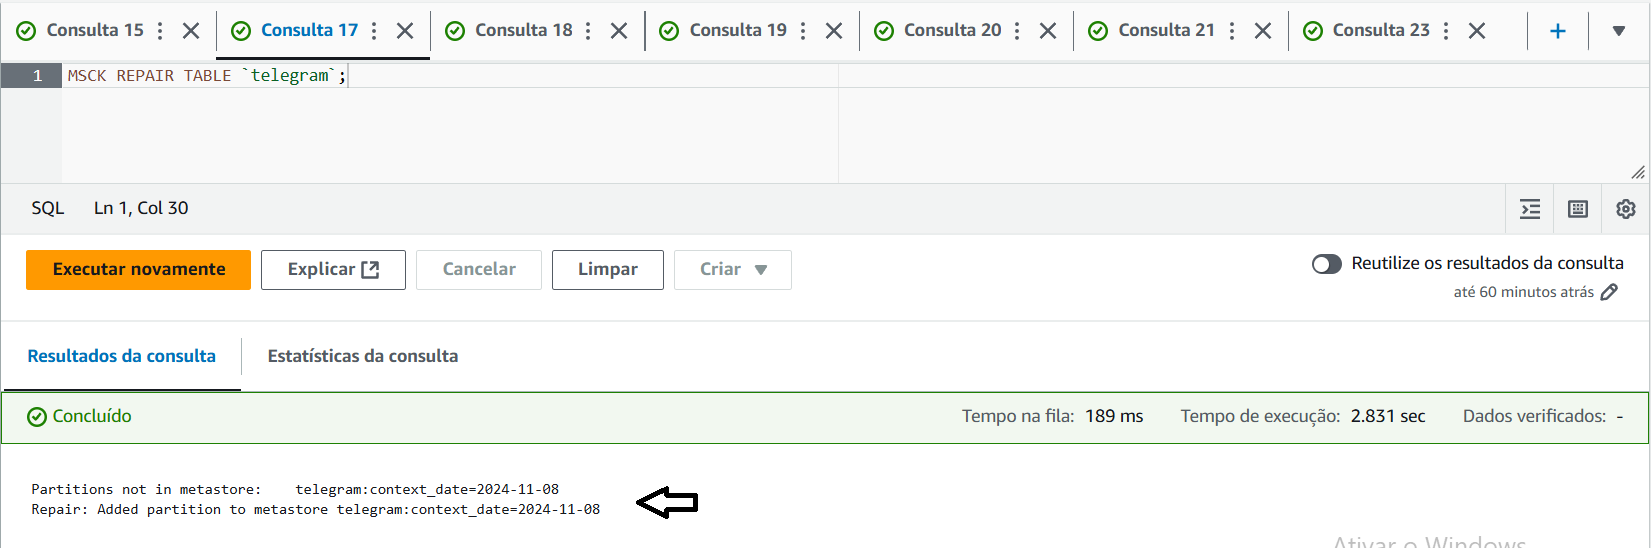

4.3. Resultado das consultas SQL para explorar os dados.

Por ter um volume pequeno de dados fiz apenas consultas básicas



4.4 Query do total de mensagens por data

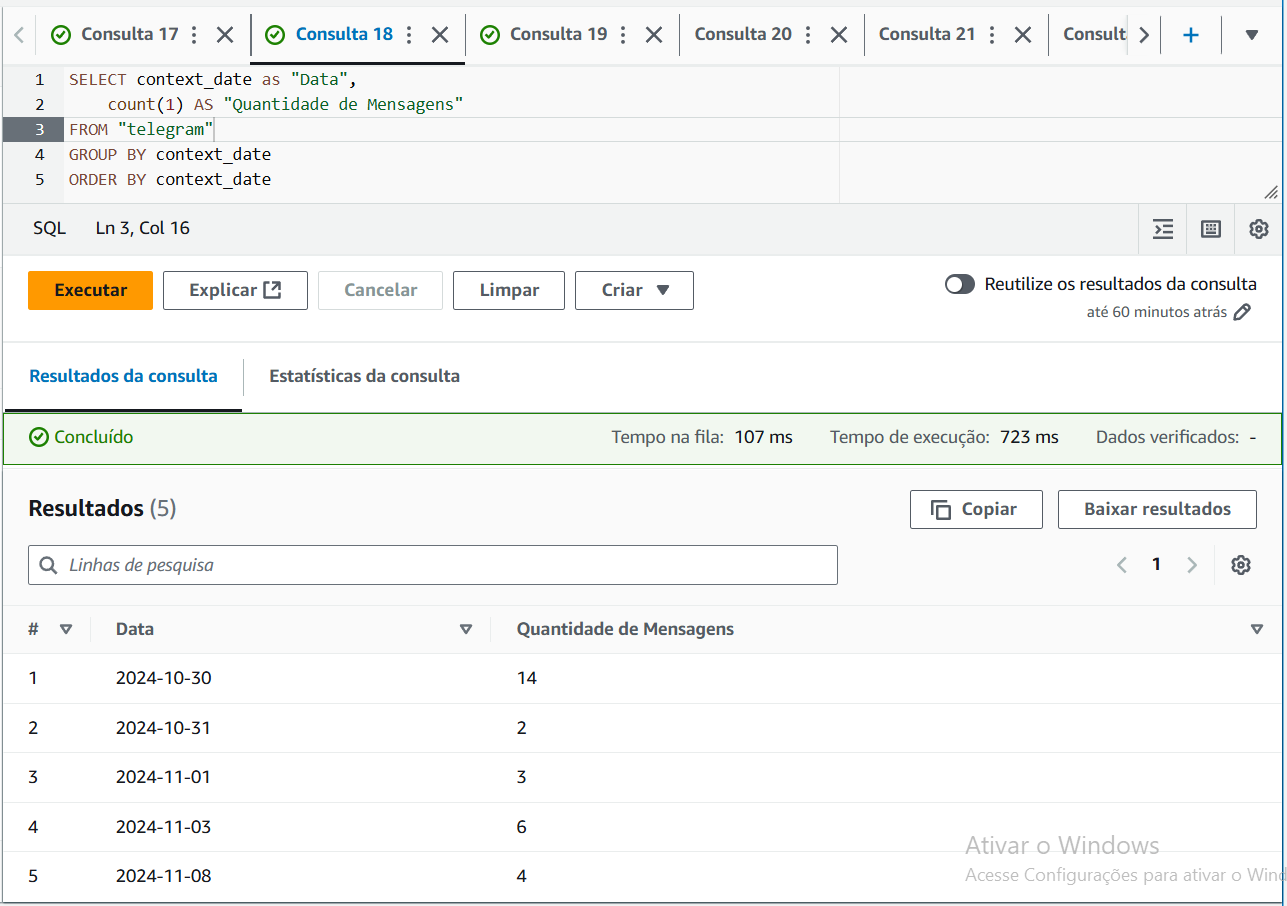

4.5 Query total de mensagens por Usuario

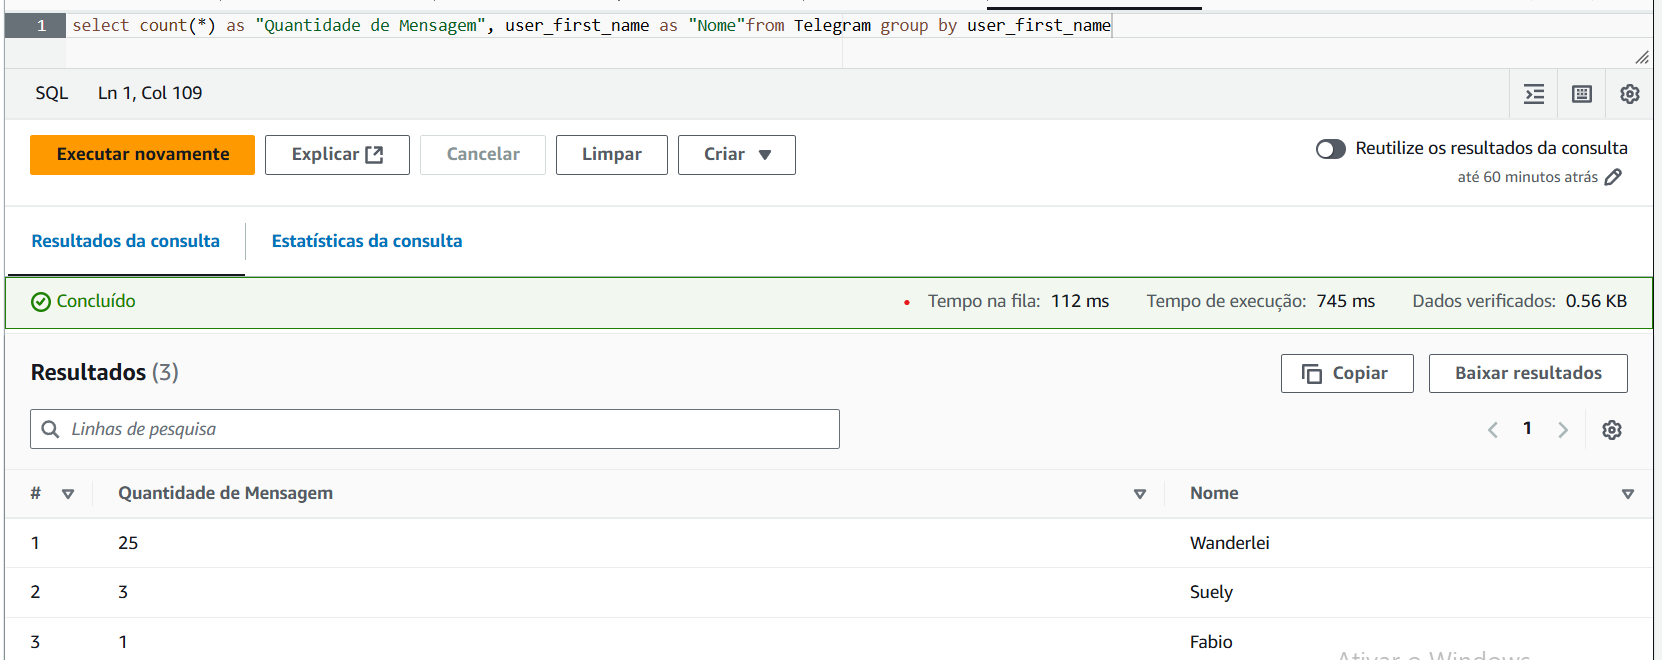

## 5\. Storytelling

**Conclusão:**

Concluímos nosso projeto, onde criamos uma Pipeline de dados obtendo informações extraídas das mensagens de um grupo de usuários do Telegram, através de um Chatbot, utilizando o Python para uma análise exploratória dos dados.

Na etapa seguinte partimos para a computação na nuvem usando o Amazon AWS para receber esses dados do Telegram via AWS API Gateway, usando funções AWS Lambda para obter os dados, o AWS S3 Bucket para o armazenamento, o AWS Event Bridge para automatizar o processo de tratamento dos dados e por fim o AWS Athena para consultas e apresentação.

Resumo do processo:
Criamos uma função Lambda para fazer a integração da API do Telegram com o AWS API Gateway para obter os dados das mensagens brutas em formato JSON  que serao salvas num Bucket S3 particionadas por data .
Na sequencia criamos outra função Lambda para ler os dados brutos do Bucket S3, fazer o processo de ETL e salvar os dados enriquecidos em um novo Bucket S3 tambem particionados por data em formato Parquet. Usamos o Event Bridge para automatizar este processo criando um gatilho que sera executado diariamente as 03h da manha.
Para finalizar criamos uma tabela do Athena que ira utilizar os dados do Bucket enriquecido para realizar as consultas SQL e apresentar o resultado das analises realizadas.